# Creating Adversarial Attack easily using FoolBox package and Keras

Provides an API for the generation of adversarial attacks in an easy and compact way. 
You need to specify:
* **Criteria**: defines whether the adversarial attack is targeted (try to replace the correct prediction with an specific label) or untargeted (tries to fool the net regardless the estimated label)
* **Attacks**: specifies different types of attacks split in 3 categories:
     * Gradient-base attacks
     * Score-based attacks
     * Decision-based attacks
     * Other attacks

In [1]:
import foolbox
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt

%matplotlib inline

/home/djcabello/miniconda2/envs/biometrics_py27/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def visualize_attack(raw_img, adversarial_img):
    
    fig = plt.figure()
    plt.subplots(1,3,figsize=(10,8))
    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(raw_img / 255)  # division by 255 to convert [0, 255] to [0, 1]
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial_img[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial_img[:, :, ::-1] - raw_img
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

    plt.show()

In [3]:
# instantiate model
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

# get source image and label
image, label = foolbox.utils.imagenet_example()

## Attack Type 1. Gradient-based attacks
### GradientSignAttack (untargeted)
Adds the sign of the gradient to the image, gradually increasing the magnitude until the image is misclassified.

**OriginalClassProbability** *criteria defines adversarials as images for which the probability of the original class is below a given threshold. This criterion alone does not guarantee that the class predicted for the adversarial image is not the original class (unless p < 1 / number of classes). Therefore, it should usually be combined with a classifcation criterion.*

In [28]:
# Different adversarial criteria such as Top-k, specific target classes or target probability
# values for the original class or the target class can be passed to the attack,
criterion = foolbox.criteria.OriginalClassProbability(0.1)
attack    = foolbox.attacks.GradientSignAttack(fmodel, criterion)
adversarial = attack(image[:, :, ::-1], label)

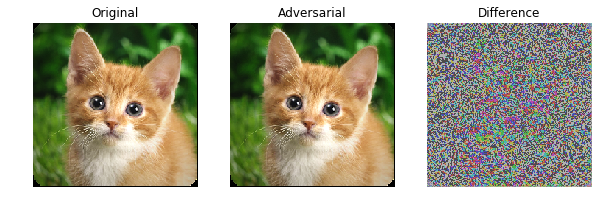

In [29]:
visualize_attack(image, adversarial)

### IterativeGradientSignAttack (untargeted)
Like GradientSignAttack but with several steps for each epsilon.
**Misclassification** *criteria defines adversarials as images for which the predicted class is not the original class.*

In [ ]:
criterion = foolbox.criteria.Misclassification()
attack    = foolbox.attacks.IterativeGradientSignAttack(fmodel, criterion)

adversarial = attack(image[:, :, ::-1], label)

In [ ]:
visualize_attack(image, adversarial)

### GradientAttack - FGSM (untargeted)
Perturbs the image with the gradient of the loss w.r.t. the image, gradually increasing the magnitude until the image is misclassified.
Does not do anything if the model does not have a gradient.

**TopKMisclassification** *criteria defines adversarials as images for which the original class is not one of the top k predicted classes. For k = 1, the Misclassification class provides a more efficient implementation.*

In [30]:
# apply attack on source image
# ::-1 reverses the color channels, because Keras ResNet50 expects BGR instead of RGB
criterion = foolbox.criteria.TopKMisclassification(k=3)
attack = foolbox.attacks.FGSM(fmodel)
adversarial = attack(image[:, :, ::-1], label)

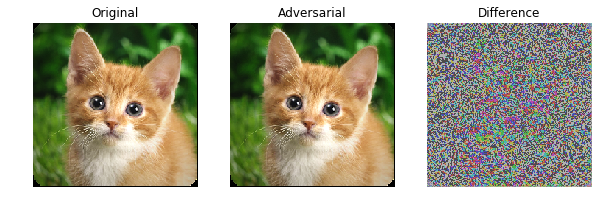

In [31]:
visualize_attack(image, adversarial)

### LBFGSAttack (targeted by target class)
Uses L-BFGS-B to minimize the distance between the image and the adversarial as well as the cross-entropy between the predictions for the adversarial and the the one-hot encoded target class.
If the criterion does not have a target class, a random class is chosen from the set of all classes except the original one.

**Target** *class criteria defines adversarials as images for which the predicted class is the given target class.*

In [11]:
# Different adversarial criteria such as Top-k, specific target classes or target probability
# values for the original class or the target class can be passed to the attack,
criterion = foolbox.criteria.TargetClass(22)
attack    = foolbox.attacks.LBFGSAttack(fmodel, criterion)

adversarial = attack(image[:, :, ::-1], label)

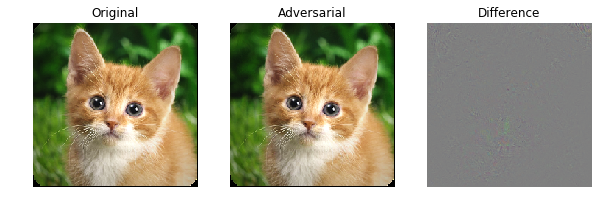

In [12]:
visualize_attack(image, adversarial)

### DeepFool attack (targeted)
Simple and accurate adversarial attack based en DeepFool paper
*TargetClassProbability criteria defines adversarials as images for which the probability of a given target class is above a given threshold.*

In [22]:
# Different adversarial criteria such as Top-k, specific target classes or target probability
# values for the original class or the target class can be passed to the attack,
criterion = foolbox.criteria.TargetClassProbability(22, p=0.98)
attack    = foolbox.attacks.DeepFoolAttack(fmodel) #, criterion)

adversarial = attack(image[:, :, ::-1], label)

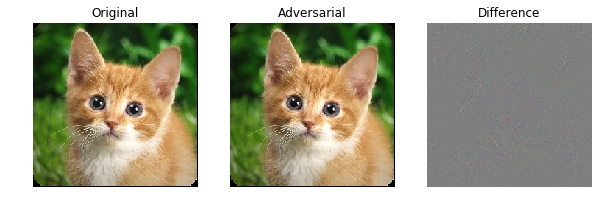

In [23]:
visualize_attack(image, adversarial)

## Attack Type 2. Score-based attacks
### Single Pixel Attack
Perturbs just a single pixel and sets it to the min or max.

In [ ]:
criterion = foolbox.criteria.Misclassification()
attack    = foolbox.attacks.SinglePixelAttack(fmodel, criterion)

adversarial = attack(image[:, :, ::-1], label)

In [ ]:
visualize_attack(image, adversarial)

### Local Search attack
A black-box attack based on the idea of greedy local search.

This implementation is based on the algorithm in http://foolbox.readthedocs.io/en/latest/modules/attacks/score.html#r1919

In [ ]:
criterion = foolbox.criteria.Misclassification()
attack    = foolbox.attacks.LocalSearchAttack(fmodel, criterion)

adversarial = attack(image[:, :, ::-1], label)

In [ ]:
visualize_attack(image, adversarial)

## Attack Type 3. Decision-based attacks
### Boundary attack
A powerful adversarial attack that requires neither gradients nor probabilities.

In [35]:
criterion = foolbox.criteria.Misclassification()
attack    = foolbox.attacks.BoundaryAttack(fmodel, criterion)

adversarial = attack(image[:, :, ::-1], label)

Step 0: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 1: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.59212 seconds)
Step 2: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.60953 seconds)
Step 3: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.61626 seconds)
Step 4: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.50670 seconds)
Step 5: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.52087 seconds)
Step 6: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.64986 seconds)
Step 7: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.52325 seconds)
Step 8: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.45181 seconds)
Step 9: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.49559 seconds)
Step 10: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02:  (took 7.59675 seconds)
Step 11: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.69126 seconds)
Step 12: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.58864 seconds)
Step 13: 1.12793e-02, stepsizes = 1.0e-02/1.0e-02:  (took 

KeyboardInterrupt: 

In [ ]:
visualize_attack(image, adversarial)

### Gaussian Blur attack
Blurs the image until it is misclassified.

In [37]:
criterion = foolbox.criteria.Misclassification()
attack    = foolbox.attacks.BoundaryAttack(fmodel, criterion)

adversarial = attack(image[:, :, ::-1], label)

Step 0: 1.11560e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 1: 1.11560e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.69867 seconds)
Step 2: 1.11560e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.49912 seconds)
Step 3: 1.11560e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.55829 seconds)
Step 4: 1.11560e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.72505 seconds)
Step 5: 1.11560e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.56419 seconds)
Step 6: 1.11560e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.53759 seconds)
Step 7: 1.11560e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.66850 seconds)
Step 8: 1.11560e-02, stepsizes = 1.0e-02/1.0e-02:  (took 3.83688 seconds)
Step 9: 1.11560e-02, stepsizes = 1.0e-02/1.0e-02:  (took 4.04047 seconds)
Step 10: 1.11560e-02, stepsizes = 1.0e-02/1.0e-02:  (took 7.80332 seconds)
Step 11: 1.11560e-02, stepsizes = 1.0e-02/1.0e-02:  (took 4.26075 seconds)
Step 12: 1.11560e-02, stepsizes = 1.0e-02/1.0e-02:  (took 4.05797 seconds)
Step 13: 1.09340e-02, stepsizes = 1.0e-02/1.0e-02: d. redu

In [ ]:
visualize_attack(image, adversarial)